# Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from   sklearn.cluster import KMeans
import nibabel as nib
import scipy.ndimage as ndi
import numpy as np
import cv2
import pywt
import pywt.data
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "drive/MyDrive/Picture/"
img_path = os.path.join(root_path, 'anita_1.nii')

# Parameters

In [ ]:
cluster_count = 15 # Number of Clusters in first level
label_limit = 3 # Second level refinement
level_count = 5 # Number of levels in DWT
distance_color_scale = 100 # Weightage of color in distance metric
classification_scale = 1 # Range = [0,1]. This is used for final segmentation AFTER KMeans has completed. Higher value gives preference to classification based on color

In [ ]:
image_id = 290

# Demonstration of k-means clustering

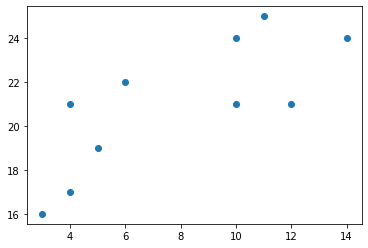

In [ ]:
x = [4, 5, 10, 4, 3, 11, 14 , 6, 10, 12]
y = [21, 19, 24, 17, 16, 25, 24, 22, 21, 21]

plt.scatter(x, y)
plt.show()

In [ ]:
data = list(zip(x, y))
kmeans = KMeans(n_clusters=4).fit(data)
centers = kmeans.cluster_centers_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


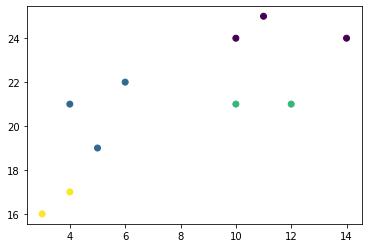

In [ ]:
plt.scatter(x, y, c=kmeans.labels_)
plt.show()

# Wavelet transform demonstration

In [ ]:
def DWT_trans(original):
  LL, (LH, HL, HH) = pywt.dwt2(original, 'haar')
  return LL

In [ ]:
def normalize(matrix):
  lar = (np.amax(matrix))
  sml = (np.amin(matrix))
  delta = lar - sml
  matrix = (matrix - sml) / delta
  matrix *= distance_color_scale
  return matrix

In [ ]:
x = nib.load(img_path)
x_ = x.get_fdata()
load_image = x_[:,:,image_id]
load_image = normalize(load_image)

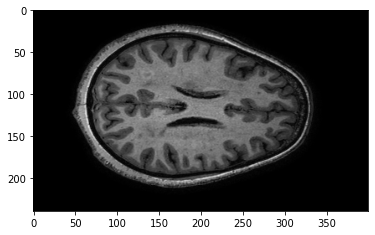

In [ ]:
plt.imshow(load_image, cmap="gray");

In [ ]:
levels = []
original = load_image
for i in range(level_count):
  levels.append(original.copy())
  original = DWT_trans(original)
  original = normalize(original)
levels.reverse()
original = load_image

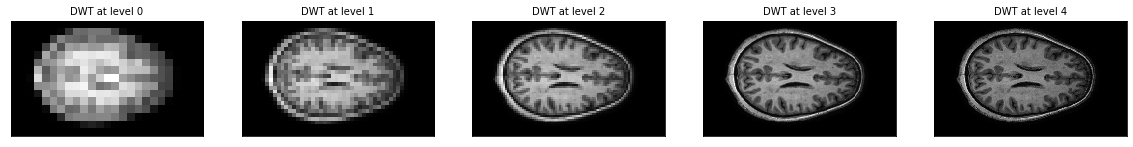

In [ ]:
fig = plt.figure(figsize=(20, 5))
for i, a in enumerate(levels):
    ax = fig.add_subplot(1, level_count, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title( "DWT at level " + str(i), fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def get_centres(image_data,previous_centres = []):
  new_centres = []
  if len(previous_centres) != 0:
    for x in previous_centres:
      c = 2 * x
      new_centres.append(c.copy())
  new_centres = np.array(new_centres)
  data = []
  for i in range(len(image_data)):
    for j in range(len(image_data[0])):
      data.append(np.array([i,j,image_data[i][j]]))
  if len(previous_centres) != 0:
    kmeans = KMeans(n_clusters=cluster_count,init = new_centres,n_init = 1).fit(data)
  else:
    kmeans = KMeans(n_clusters=cluster_count).fit(data)
  return kmeans.cluster_centers_

In [ ]:
centres = np.array([])
for i, a in enumerate(levels):
    if(len(centres) == 0):
      centres = get_centres(levels[i])
    else:
      centres = get_centres(levels[i],centres)
centres = np.array(centres)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def dist(a,b):
  return ((abs(a[0]-b[0])**2 + abs(a[1]-b[1])**2) * (1 - classification_scale)) + ((abs(a[2] - b[2]) ** 2) * classification_scale)

In [ ]:
color_labels = [
    ['Black',(0,0,0)],
    ['Lime',(0,255,0)],
    ['Blue',(0,0,255)],
    ['Yellow',(255,255,0)],
    ['Cyan',(0,255,255)],
    ['Magenta',(255,0,255)],
    ['Maroon',(128,0,0)],
    ['Green',(0,128,0)],
    ['Purple',(128,0,128)],
    ['Navy',(0,0,128)]
]
mask = list(original.copy())
freq = [[0,centres[i]] for i in range(cluster_count)]
for i in range(len(mask)):
  mask[i] = list(mask[i])
  for j in range(len(mask[i])):
    best = 1e18
    which = -1
    for k in range(len(centres)):
      if(best > dist([i,j,original[i][j]],centres[k])):
        best = dist([i,j,original[i][j]],centres[k])
        which = k
    mask[i][j] = color_labels[which % len(color_labels)][1]
    freq[which][0] += 1
freq = sorted(freq,key=lambda x: x[0])
freq.reverse()

# Initial Clustering

[]

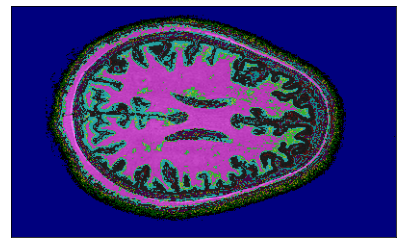

In [ ]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(1, level_count,1)
ax.imshow(original, interpolation="nearest", cmap=plt.cm.gray)
ax.imshow(mask, cmap='jet', alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
centres = []
for k in range(label_limit):
  centres.append(freq[k][1])

In [ ]:
mask = list(original.copy())
for i in range(len(mask)):
  mask[i] = list(mask[i])
  for j in range(len(mask[i])):
    best = 1e18
    which = -1
    for k in range(len(centres)):
      if(best > dist([i,j,original[i][j]],centres[k])):
        best = dist([i,j,original[i][j]],centres[k])
        which = k
    mask[i][j] = color_labels[which % len(color_labels)][1]

In [ ]:
new_mask = mask.copy()
for i in range(len(mask)):
  for j in range(len(mask[i])):
    if mask[i][j] == (0,0,0):
      aage = False
      peche = False
      for x in range(i,len(mask)):
        if mask[x][j] != (0,0,0):
          aage = True
          break
      for x in range(i):
        if mask[x][j] != (0,0,0):
          peche = True
          break
      if aage and peche:
        new_mask[i][j] = color_labels[3][1]
mask = new_mask

# After refinement

[]

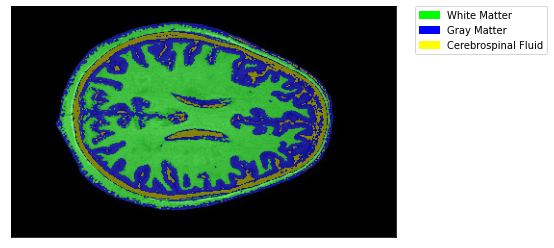

In [ ]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(1, level_count,1)
ax.imshow(original, interpolation="nearest", cmap=plt.cm.gray)
ax.imshow(mask, cmap='jet', alpha=0.5)
lbls = ["Background","White Matter","Gray Matter","Cerebrospinal Fluid"]
patches = [ mpatches.Patch(color=('#%02x%02x%02x' % color_labels[i][1]), label="{l}".format(l=lbls[i]) ) for i in range(1,label_limit + 1) ]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
ax.set_xticks([])
ax.set_yticks([])